In [1]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv3D, Dense, Flatten, GlobalAveragePooling2D, Conv2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [2]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.utils import plot_model

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import matplotlib.font_manager as fm

C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import gc
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

#### KMA's ASOS, AWS Weather DATA (2017.07.01 00:00 ~ 2019.07.01 00:00 freq=H)

In [5]:
selected_col = ['temperature', 'wind-direction', 'wind-speed', 'Precipitation', 'humidity', 'pressure' , 'Sea level pressure', 'cloud amount', 'mid-low cloud amount', 'minimum cloud height']

In [6]:
df_weather = pd.read_csv('./data/total_weather.csv').drop('Unnamed: 0', axis=1)
df_weather.columns = ['location', 'datetime', 'temperature', 'wind-direction', 'wind-speed', 'Precipitation', 'humidity', 'pressure' , 'Sea level pressure', 'cloud amount', 'mid-low cloud amount', 'minimum cloud height', 'lat', 'lon']
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather.head()

,location,datetime,temperature,wind-direction,wind-speed,Precipitation,humidity,pressure,Sea level pressure,cloud amount,mid-low cloud amount,minimum cloud height,lat,lon
0,90,2017-07-01 00:00:00,26.9,320.0,1.0,NaN,51.0,1002.4,1004.4,NaN,NaN,NaN,87,142
1,90,2017-07-01 01:00:00,26.5,360.0,1.4,NaN,53.0,1002.1,1004.1,NaN,NaN,NaN,87,142
2,90,2017-07-01 02:00:00,26.4,340.0,2.1,NaN,56.0,1001.9,1003.9,NaN,NaN,NaN,87,142
3,90,2017-07-01 03:00:00,28.1,270.0,2.6,NaN,52.0,1001.1,1003.1,NaN,NaN,NaN,87,142
4,90,2017-07-01 04:00:00,26.3,290.0,1.1,NaN,60.0,1001.5,1003.5,NaN,NaN,NaN,87,142


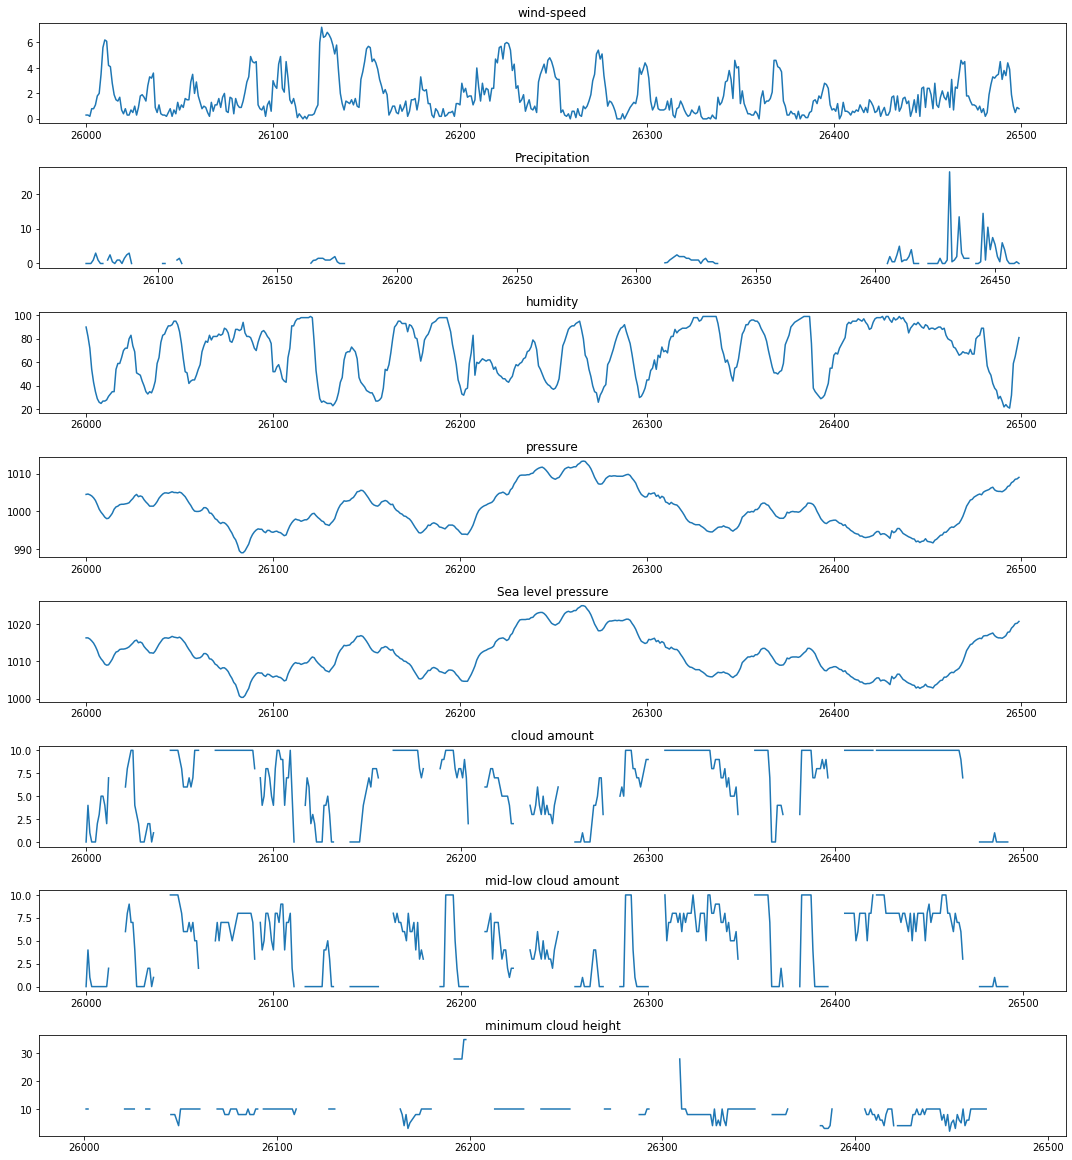

In [7]:
plt.figure(figsize=(15,20))
for i, f in zip(range(1,11), selected_col[2:]):
    ax = plt.subplot(10, 1, i)
    ax.set_title(f)
    ax.plot(df_weather[f][26000:26500])
    plt.tight_layout()

#### Fill missing values

In [8]:
points = df_weather['location'].unique()

In [ ]:
df_resampled_weather = pd.DataFrame(columns=selected_col)
for point in points:
    one_point = df_weather[df_weather['location']==point].interpolate(mathod='linear')
    one_point['wind-direction'].interpolate(method='nearest', inplace=True)
    one_point[['temperature', 'wind-speed', 'Precipitation', 'humidity', 'pressure' , 'Sea level pressure', 'cloud amount', 'mid-low cloud amount', 'minimum cloud height']].interpolate(method='linear', inplace=True)
    df_resampled_weather = pd.concat([df_resampled_weather, one_point])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [ ]:
plt.figure(figsize=(15,20))
for i, f in zip(range(1,11), selected_col[2:]):
    ax = plt.subplot(10, 1, i)
    ax.set_title(f)
    ax.plot(df_resampled_weather[f][26000:26500])
    plt.tight_layout()

#### Filling missing values(Data preprocessing)

#### Data save, Load

In [203]:
df_resampled_weather.to_csv('./data/total_weather_resampled.csv')

In [11]:
df_resampled_weather = pd.read_csv('./data/total_weather_resampled.csv')
df_resampled_weather['datetime'] = pd.to_datetime(df_resampled_weather['datetime'])

KeyError: 'datetime'

## Data Preprocess

In [59]:
times = pd.date_range(min(df_resampled_weather['datetime']), pd.Timestamp('2019-07-01T00'), freq='H')

### Finding Meteorological station 

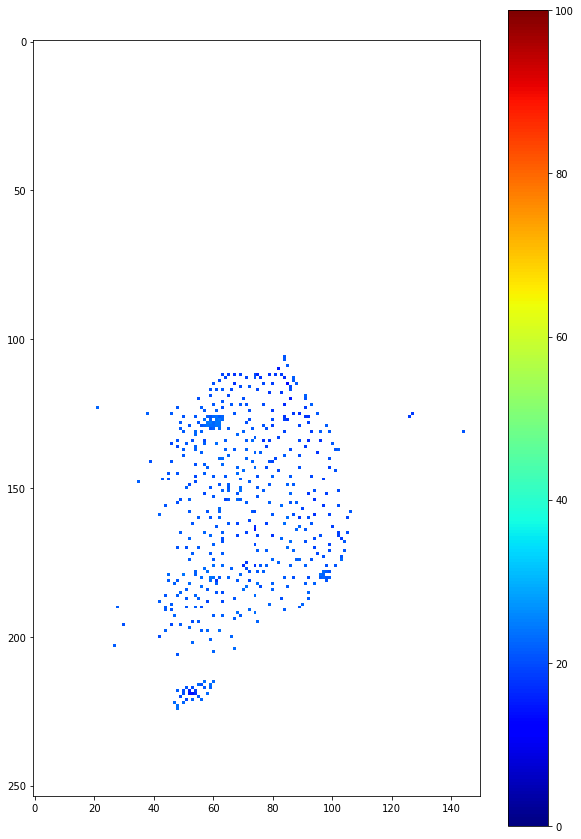

In [420]:
grid_array = np.zeros((253+1, 149+1))
for t, y, x in zip(test_info['temperature'], test_info['lat'], test_info['lon']):
    try :
        grid_array[253+1-x, y] = t
    except :
        pass
fig = plt.figure(figsize=(10, 15))
masked_data = np.ma.masked_where(grid_array < 0.5, grid_array)
plt.imshow(masked_data, cmap='jet', vmin=0, vmax=100, alpha=1)
plt.colorbar()
plt.show()

### Filling blank spots(Interpolate) 

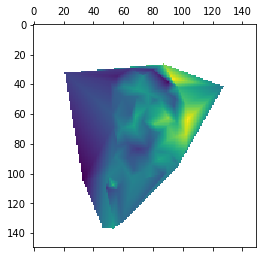

In [67]:
test_info = df_resampled_weather[df_resampled_weather['datetime']==times[0]]
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1)) # Cropping
zi = griddata((test_info['lat'].values, test_info['lon'].values), test_info['temperature'].values, (xi, yi),method='linear')
plt.matshow(np.flipud(zi))

### Fill the White-blank-spots by nearest value.

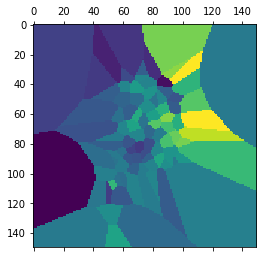

In [68]:
mask_zi = griddata((test_info['lat'].values, test_info['lon'].values), test_info['temperature'].values, (xi, yi),method='nearest')
plt.matshow(np.flipud(mask_zi))

### Adding two above images.

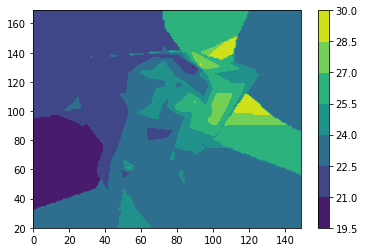

In [57]:
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
cb = plt.contourf(xi, yi, zi)
plt.colorbar(cb)
plt.show(cb)

### Scaling (Robust)

In [27]:
sc = RobustScaler()

In [28]:
sc.fit(df_resampled_weather[selected_col[2:]])
df_resampled_weather[selected_col[2:]] = sc.transform(df_resampled_weather[selected_col[2:]])

#### save Scaler

In [29]:
joblib.dump(sc, './data/scaler.pkl')

['./data/scaler.pkl']

In [30]:
sc = joblib.load('./data/scaler.pkl')

In [31]:
times = pd.date_range(min(df_resampled_weather['datetime']), pd.Timestamp('2019-07-01T00'), freq='H')

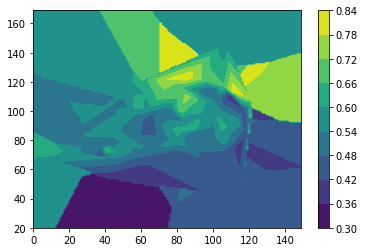

In [32]:
test_info = df_resampled_weather[df_resampled_weather['datetime']==times[0]]
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['temperature'].values, (xi, yi),method='linear')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['temperature'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
cb = plt.contourf(xi, yi, zi.T)
plt.colorbar(cb)
plt.show(cb)

### For easier training, we diminished the unit.

In [ ]:
data = np.zeros((len(times), 10, 75, 75))
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((10, 75, 75))
    test_info = df_resampled_weather[df_resampled_weather['datetime']==time]
    
    for ft, j in zip(selected_col[2:], range(10)):
        xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
        zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info[ft].values, (xi, yi), method='linear')
        mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info[ft].values, (xi, yi), method='nearest')
        zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
        zi[np.isnan(zi)] = np.nanmean(zi)
        images[j] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
        
    data[i] = images[:,:]

## scale amount of generation

In [48]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen.columns = ['datetime', 'generation']
wind_gen['datetime'] = pd.to_datetime(wind_gen['datetime'])

In [49]:
wind_gen.head()

,datetime,generation
0,2017-07-01 01:00:00,1.09776
1,2017-07-01 02:00:00,1.38600
2,2017-07-01 03:00:00,0.54600
3,2017-07-01 04:00:00,0.00000
4,2017-07-01 05:00:00,7.16832


#### Robust Scaler

In [10]:
sc = RobustScaler()
sc.fit(wind_gen[['generation']])
wind_gen[['generation']] = sc.transform(wind_gen[['generation']])

In [14]:
joblib.dump(sc, './data/scaler_gen.pkl')

['./data/scaler_gen.pkl']

In [50]:
wind_gen.head()

,datetime,generation
0,2017-07-01 01:00:00,1.09776
1,2017-07-01 02:00:00,1.38600
2,2017-07-01 03:00:00,0.54600
3,2017-07-01 04:00:00,0.00000
4,2017-07-01 05:00:00,7.16832


### Save data to disk using h5py library

#### Segregate 2017 datas(Due to memory limits)

In [71]:
len(pd.date_range(pd.Timestamp('2017-07-01T00'), pd.Timestamp('2017-12-31T23'), freq='H'))

4416

In [72]:
len(wind_gen.iloc[:4416])

4416

In [73]:
data[:4416].shape

(4416, 10, 75, 75)

In [74]:
wind_2017 = wind_gen[wind_gen['datetime'] <= pd.Timestamp('2018-01-01T00')]
len(wind_2017['generation'].values)

4416

In [75]:
wind_2017.shape

(4416, 2)

In [76]:
h5f = h5py.File('D:/total_data.h5', 'w')

In [77]:
h5f.create_dataset('total_2017', data=data[:4416])
h5f.create_dataset('gen_2017', data=wind_2017['generation'].values)
#h5f.close()

<HDF5 dataset "gen_2017": shape (4416,), type "<f8">

#### Segregate 2018 datas(Due to memory limits)

In [78]:
len(pd.date_range(pd.Timestamp('2018-01-01T00'), pd.Timestamp('2018-12-31T23'), freq='H'))

8760

In [79]:
len(wind_gen.iloc[4416:13176])

8760

In [80]:
data[4416:13176].shape

(8760, 10, 75, 75)

In [81]:
wind_2018 = wind_gen[(wind_gen['datetime'] > pd.Timestamp('2018-01-01T00')) & (wind_gen['datetime'] <= pd.Timestamp('2019-01-01T00'))]
len(wind_2018['generation'].values)

8760

In [82]:
h5f.create_dataset('total_2018', data=data[4416:13176])
h5f.create_dataset('gen_2018', data=wind_2018['generation'].values)
#h5f.close()

<HDF5 dataset "gen_2018": shape (8760,), type "<f8">

#### Segregate 2019 datas(Due to memory limits)

In [83]:
len(pd.date_range(pd.Timestamp('2019-01-01T00'), pd.Timestamp('2019-06-30T23'), freq='H'))

4344

In [84]:
len(wind_gen.iloc[13176:])

4344

In [85]:
wind_2019 = wind_gen.iloc[13176:]
len(wind_2019)

4344

In [86]:
data[13176:17520].shape

(4344, 10, 75, 75)

In [87]:
h5f.create_dataset('total_2019', data=data[13176:17520])
h5f.create_dataset('gen_2019', data=wind_2019['generatioin'].values)
h5f.close()

#### Check Data

In [37]:
h5f = h5py.File('./data/data_2018.h5','r')

In [38]:
data = h5f['total_2018'][:]
gen_data = h5f['gen_2018'][:]
h5f.close()

In [39]:
data.shape, gen_data.shape

((8760, 7, 75, 75), (8760,))

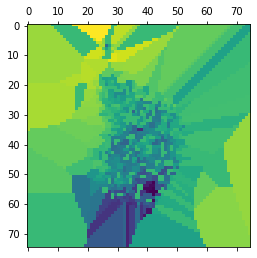

In [28]:
plt.matshow(data[0,0,:,:])

### Train Model

#### Import Data

In [ ]:
h5f = h5py.File('D:/total_data_ro.h5', 'r')
data_train = h5f['total_2018'][:]
gen_data_train = h5f['gen_2018'][:]
data_val = h5f['total_2017'][:]
gen_data_val = h5f['gen_2017'][:]
h5f.close()

In [ ]:
sc = joblib.load('./data/scaler_gen.pkl')
gen_data_train = sc.transform(gen_data_train.reshape(1, -1))
gen_data_train = gen_data_train.reshape(-1, 1)
gen_data_val = sc.transform(gen_data_val.reshape(1, -1))
gen_data_val = gen_data_val.reshape(-1, 1)

In [ ]:
data_train = np.rollaxis(data_train, 1, 4)
data_val = np.rollaxis(data_val, 1, 4)

In [ ]:
callbacks_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5
    ),
    ModelCheckpoint(
        filepath='best_conv1x1.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

### 1 Hour Prediction Model

![title](data/mm_data_robust_gen_1.png)

In [ ]:
model = Sequential()

    model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=rmsprop(lr=0.001), loss='mae')
model.summary()

#### Define Generator

##### random input data(Impossible to Load the whole data to memory)

In [ ]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = target[rows[j] + delay - 1]
        yield samples, targets

In [ ]:
train_gen = generator(data_train, gen_data_train, 72, 0, 0, None, shuffle=True, batch_size=20)
val_gen = generator(data_val, gen_data_val, 72, 0, 0, None, shuffle=True, batch_size=20)

#### Train Model

#### Training model by calibrating Weight, Bias 

In [ ]:
history = model.fit_generator(train_gen, validation_data=val_gen,
                              steps_per_epoch=20, validation_steps=20,
                             epochs=100, use_multiprocessing=True, callbacks=callbacks_list)

#### Model Evaluate

In [28]:
h5f = h5py.File('D:/total_data_mm.h5','r')
test_data = h5f['total_2019'][:]
test_gen_data = h5f['gen_2019'][:]
h5f.close()

In [29]:
model.load_weights('./data/mm_data_robust_gen_1.h5')

In [30]:
sc = RobustScaler()
sc = joblib.load('./data/scaler_gen.pkl')

In [51]:
graph_data_pred = np.array([])
graph_data_real = np.array([])

In [ ]:
for i in tqdm(range(0, 1000, 100)):
    test_gen = generator(test_data, test_gen_data, 72, 0, i, None, shuffle=False, batch_size=100)
    X_test = np.array(test_gen[0])
    X_test = np.rollaxis(X_test, 2, 5)
    y_pred = model.predict(X_test)
    y_pred = sc.inverse_transform(y_pred)
    graph_data_pred = np.append(graph_data_pred, y_pred)
    graph_data_real = np.append(graph_data_real, test_gen[1])

In [ ]:
plt.figure(figsize=(12, 5))
plt.xlim(300,960)
plt.plot(graph_data_pred, label='pred')
plt.plot(graph_data_real, label='real')
plt.legend()
plt.show()

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.figure(figsize=(15, 10))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 72 Hours Prediction model _ 1dense = 1 hour ++

![title](data/model.png)

In [ ]:
reset_keras()

img_input = Input(shape=(None, 75, 75, 10), name='images')
convlstm2d = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', return_sequences=True,
                   padding='same')(img_input)
batch_norm = layers.BatchNormalization()(convlstm2d)

convlstm2d_1x1 = layers.ConvLSTM2D(filters=1, kernel_size=(3, 3),
                    data_format='channels_last',padding='same')(batch_norm)
batch_norm = layers.BatchNormalization()(convlstm2d_1x1)

flatten = layers.Flatten()(batch_norm)

Dense_1_list = [layers.Dense(units=1)(flatten) for i in range(72)]

model = Model(img_input, Dense_1_list)

model.compile(optimizer=rmsprop(lr=0.001), loss=['mae' for i in range(72)])
model.summary()

#### Define Generator

In [ ]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), delay))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = target[rows[j] - 1: rows[j] + delay - 1][:,0]
        yield samples, [targets[:,0], targets[:,1], targets[:,2], targets[:,3], targets[:,4], targets[:,5], targets[:,6], targets[:,7], targets[:,8], targets[:,9], targets[:,10], targets[:,11], targets[:,12], targets[:,13], targets[:,14], targets[:,15], targets[:,16], targets[:,17], targets[:,18], targets[:,19], targets[:,20], targets[:,21], targets[:,22], targets[:,23], targets[:,24], targets[:,25], targets[:,26], targets[:,27], targets[:,28], targets[:,29], targets[:,30], targets[:,31], targets[:,32], targets[:,33], targets[:,34], targets[:,35], targets[:,36], targets[:,37], targets[:,38], targets[:,39], targets[:,40], targets[:,41], targets[:,42], targets[:,43], targets[:,44], targets[:,45], targets[:,46], targets[:,47], targets[:,48], targets[:,49], targets[:,50], targets[:,51], targets[:,52], targets[:,53], targets[:,54], targets[:,55], targets[:,56], targets[:,57], targets[:,58], targets[:,59], targets[:,60], targets[:,61], targets[:,62], targets[:,63], targets[:,64], targets[:,65], targets[:,66], targets[:,67], targets[:,68], targets[:,69], targets[:,70], targets[:,71]]

In [ ]:
train_gen = generator(train_data, train_gen_data, 120, 72, 0, None, shuffle=True, batch_size=5)
val_gen = generator(val_data, val_gen_data, 120, 72, 0, None, shuffle=True, batch_size=5)

#### Train Model

In [ ]:
history = model.fit_generator(train_gen, validation_data=val_gen,
                              steps_per_epoch=25, validation_steps=25,
                             epochs=100, use_multiprocessing=True, callbacks=callbacks_list)